# TSNE on the VOC2007 with the second checkpoint

In [135]:
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from torchvision import transforms, datasets
import torchvision.models as models

from voc import Voc2007Classification

from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import numpy as np


load dataset

In [157]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)        
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),        
    transforms.ToTensor(),
    normalize,
])

#train_dataset = Voc2007Classification('/shared/datasets/project29voc2012/',set='trainval',transform = transform)
val_dataset = Voc2007Classification('/home/minhan/datasets/project29voc/',set='test',transform = transform)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True)

[dataset] read /home/minhan/datasets/project29voc/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=20  number of images=4952


initialize and load models

In [138]:
model = models.__dict__['resnet50'](num_classes=128)

In [139]:
if os.path.isfile('PCL_v2_epoch200.pth'):
    print("=> loading checkpoint '{}'".format('PCL_v2_epoch200.pth'))
    checkpoint = torch.load('PCL_v2_epoch200.pth', map_location="cpu")            
    state_dict = checkpoint['state_dict']
    # rename pre-trained keys
    for k in list(state_dict.keys()):
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            state_dict[k[len("module.encoder_q."):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]  
    model.load_state_dict(state_dict, strict=False)
    model.fc = torch.nn.Identity()
    print("=> loaded pre-trained model '{}'".format('PCL_v2_epoch200.pth'))
else:
    print("=> no checkpoint found at '{}'".format('PCL_v2_epoch200.pth'))

=> loading checkpoint 'PCL_v2_epoch200.pth'
=> loaded pre-trained model 'PCL_v2_epoch200.pth'


cut off last two layers of the resnet (averagepooling and fully connected)

In [140]:
model = torch.nn.Sequential(*list(model.children())[:-2])

In [141]:
device = torch.device('cuda:0')

get features for every datapoint

In [142]:
model.to(device)
model.eval()
features = []
targets = []
with torch.no_grad():
    for data, target in val_loader:
        data = data.cuda()
        feature = model(data)
        feature = torch.flatten(feature, start_dim=1)  # Flatten the feature if necessary
        features.append(feature)
        targets.append(target)

features = torch.cat(features, dim=0)   # Concatenate the feature vectors
targets = torch.cat(targets, dim = 0)

In [144]:
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(features.cpu())

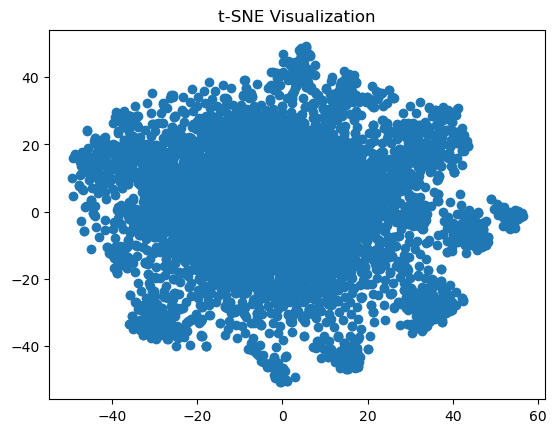

In [145]:
# Visualize the embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("t-SNE Visualization")
plt.show()

In [146]:
voc2007_labels = [
     'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]


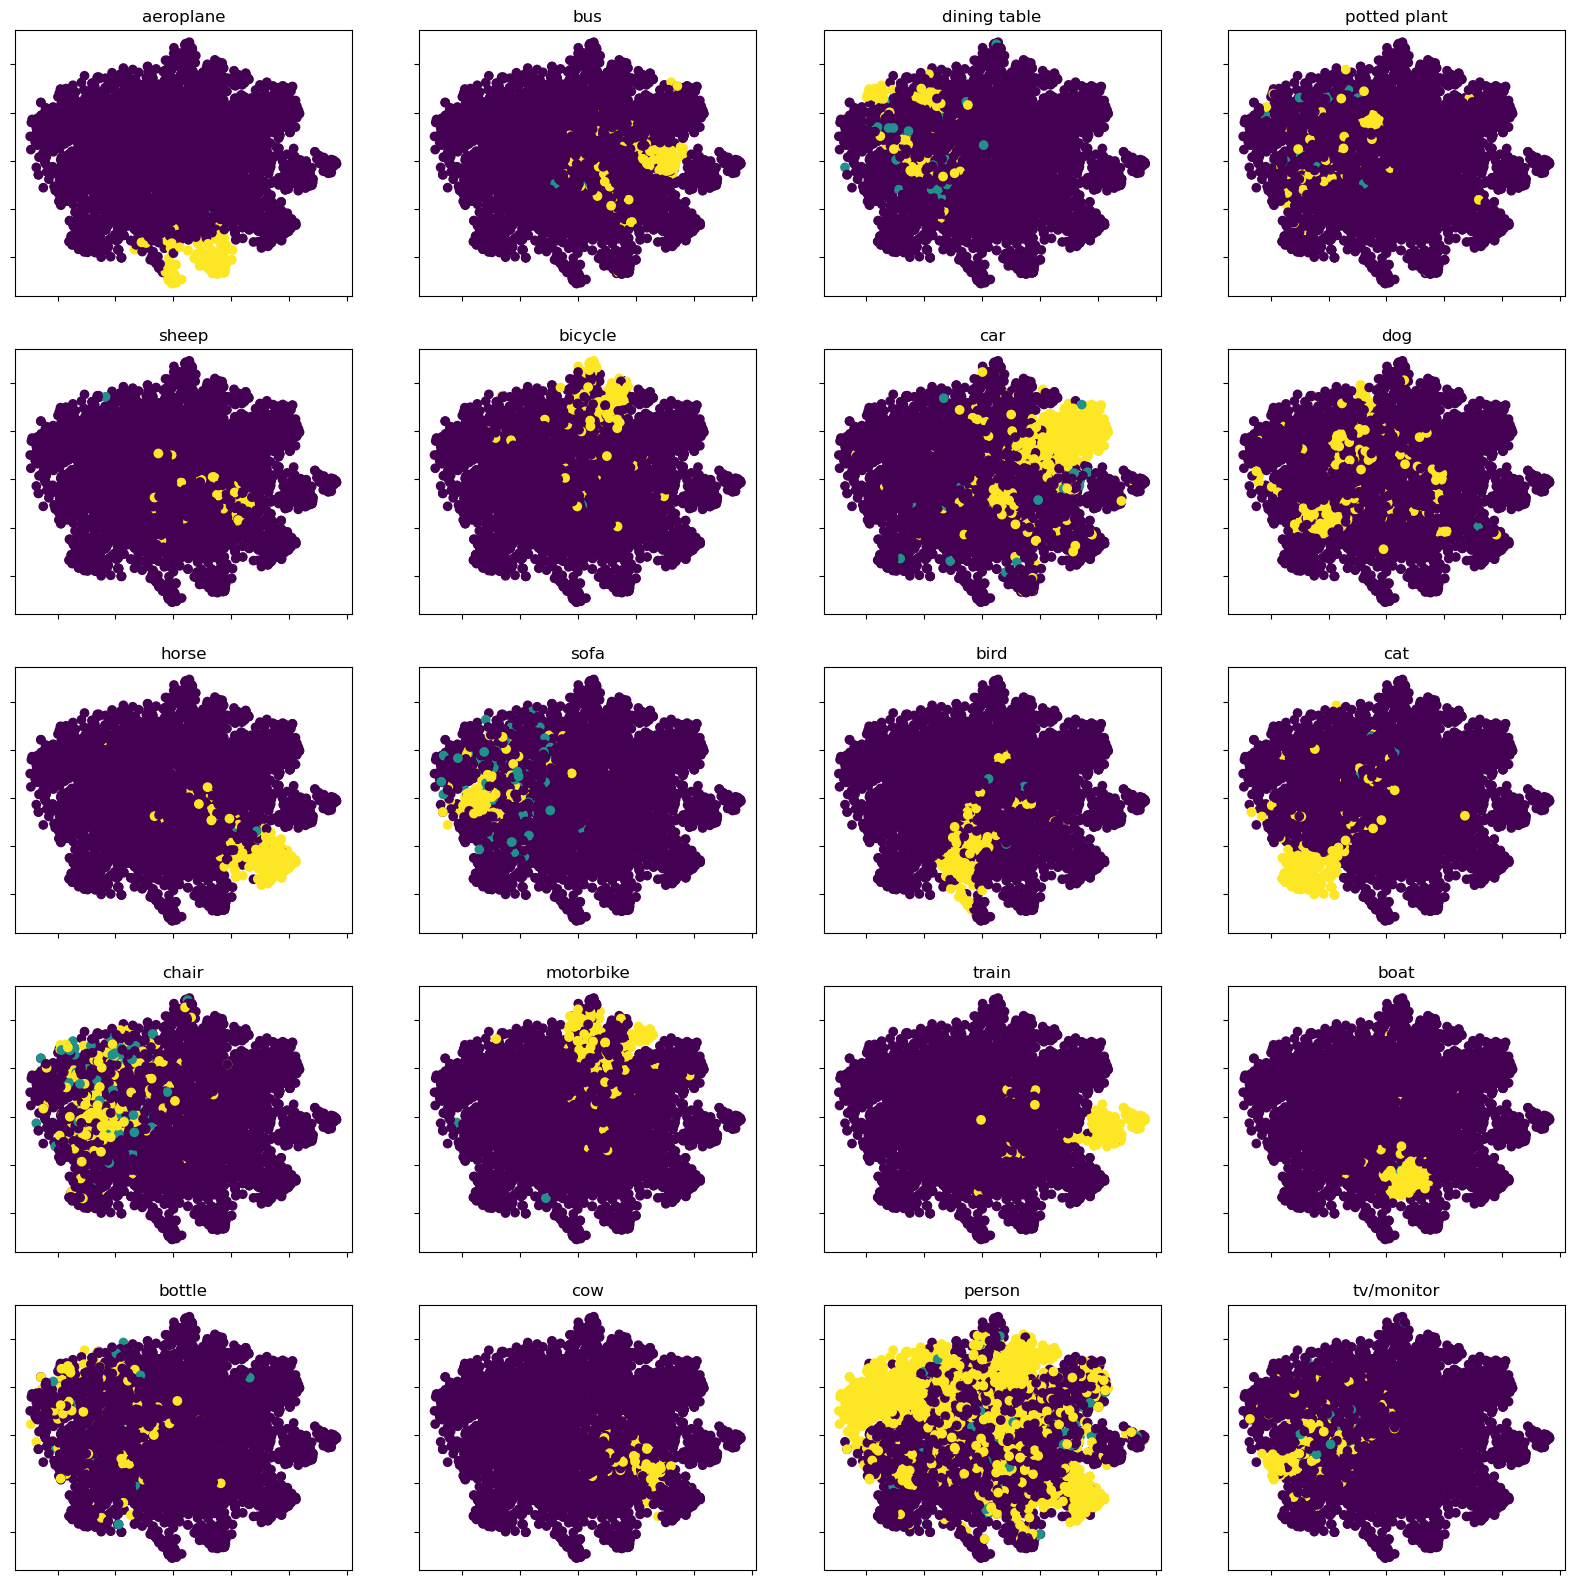

In [147]:
fig, axs = plt.subplots(5, 4)
for i in range(20):
    axs[i % 5, i % 4].scatter(embeddings[:, 0], embeddings[:, 1], c = targets[:,i],cmap='viridis' )
    axs[i % 5, i % 4].set_title(voc2007_labels[i])
    axs[i % 5, i % 4].set_xticklabels([])
    axs[i % 5, i % 4].set_yticklabels([])

fig.set_figheight(20)
fig.set_figwidth(20)


In [138]:
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=3)
embeddings3d = tsne.fit_transform(features.cpu())


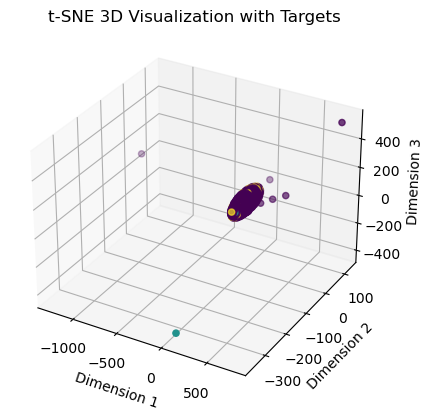

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings3d[:, 0], embeddings3d[:, 1], embeddings3d[:, 2], c=  targets[:,11])
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title("t-SNE 3D Visualization with Targets")
plt.show()